In [ ]:
"""
In this file the Decdision Tree model is tuned. 
Hyperparameters include: criteria; max depth; min samples split; min samples leaf; ccp_alpha (post pruning); 
Learning curves are constructed. 
The final model is evaluated 
"""

In [8]:
import nbimporter
import numpy as np
import pandas as pd
pd.options.display.max_columns=None
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, validation_curve, learning_curve, GridSearchCV, ParameterGrid, KFold, cross_validate
from sklearn.tree import DecisionTreeClassifier, plot_tree

import nbimporter
from Data import load_training_test_sets
import graphviz 
import time

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

## Import Data

In [9]:
X_train, X_test, y_train, y_test=load_training_test_sets()

kf = KFold(n_splits=5, shuffle=True, random_state=42)

Import Data: Complete
Train shape:  (32561, 15) 
Test shape:  (16281, 15) 
Columns:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14] 

Process and Split Data: Complete 

Undersample data: Complete
Balanced train data:  (18664, 85)
Imbalanced test data:  (9769, 85) 



## Tuning

In [55]:
def tune(X_train, y_train, param, param_range, show_plot=True):
    clf = DecisionTreeClassifier(random_state=0)
    if param!='ccp_alpha':
        clf_gs=GridSearchCV(estimator = clf, scoring='f1', param_grid=ParameterGrid({'{}'.format(param): [param_range]}))
    else:
        clf_gs=GridSearchCV(estimator = clf, scoring='f1', param_grid=ParameterGrid({'{}'.format(param): param_range}))
    clf_gs.fit(X_train, y_train)
    best_param=clf_gs.best_params_[str(param)]
    best_score=round(clf_gs.best_score_, 3)
    
    print(color.BOLD+'Tuning Parameter: {}'.format(param)+color.END)
    print('Best Parameter: ', best_param)
    print('Best Score: ', best_score)
    
    if show_plot==True: 
        if param!='ccp_alpha':
            train_scores, test_scores=validation_curve(clf, X_train, y_train, param_name=param, param_range=param_range, scoring='f1', cv=kf)
        else: 
            param_range=np.array(range(0, 40))/1000
            train_scores, test_scores=validation_curve(clf, X_train, y_train, param_name=param, param_range=param_range, scoring='f1', cv=kf)
        fig, ax = plt.subplots()
        fig.set_size_inches(10,6)
        ax.plot(range(len(param_range)), np.mean(train_scores, axis=1), '-o', label='Train')
        ax.plot(range(len(param_range)), np.mean(test_scores, axis=1), '-o', label='Val')

        ax.set_title('Validation Curve: {}'.format(param))
        ax.set_xlabel('N')
        ax.set_ylabel('F1')
        ax.set_xticks(range(len(param_range)))
        ax.set_xticklabels(param_range)
        ax.legend()
    

Tuning Parameter: criterion
Best Parameter:  entropy
Best Score:  0.774


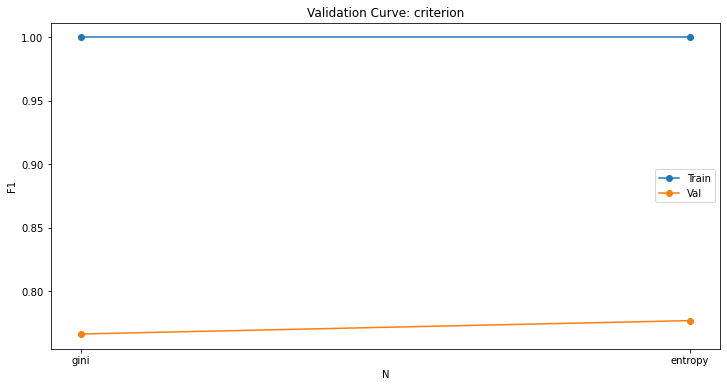

In [39]:
param='criterion'
param_range=['gini', 'entropy']
tune(X_train, y_train, param, param_range)

Tuning Parameter: max_depth
Best Parameter:  6
Best Score:  0.828


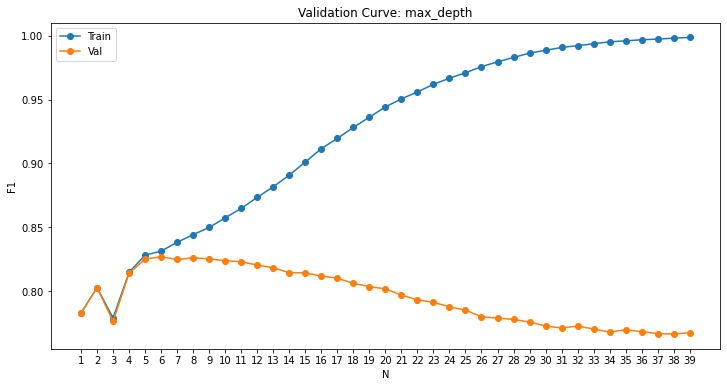

In [40]:
param='max_depth'
param_range=range(1, 40)
tune(X_train, y_train, param, param_range)

Tuning Parameter: min_samples_split
Best Parameter:  870
Best Score:  0.824


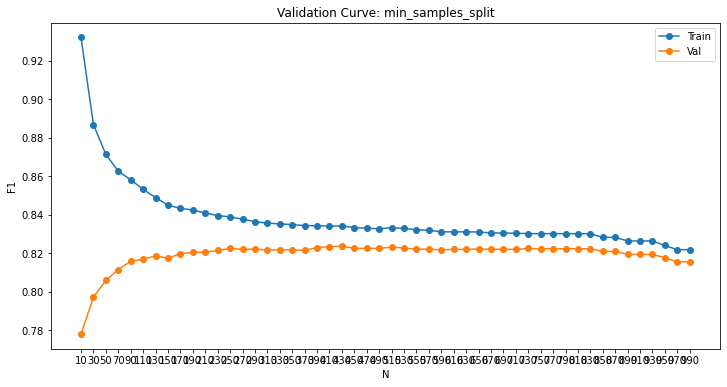

In [41]:
param='min_samples_split'
param_range=range(10, 1000, 20)
tune(X_train, y_train, param, param_range)

Tuning Parameter: min_samples_leaf
Best Parameter:  101
Best Score:  0.823


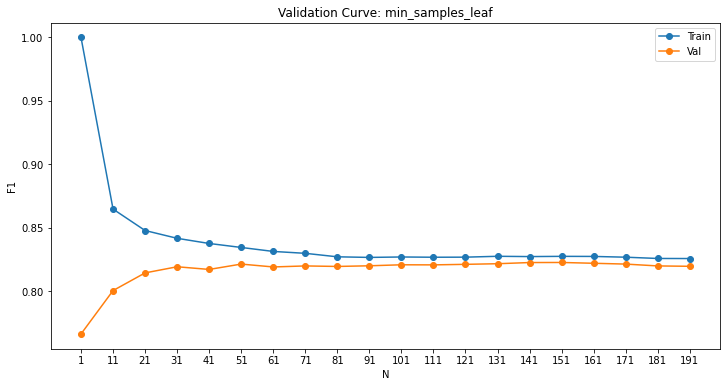

In [42]:
param='min_samples_leaf'
param_range=param_range=range(1, 200, 10)
tune(X_train, y_train, param, param_range)

In [43]:
clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
ccp_alphas.shape

(1296,)

Tuning Parameter: ccp_alpha
Best Parameter:  0.0004430638483906846
Best Score:  0.828


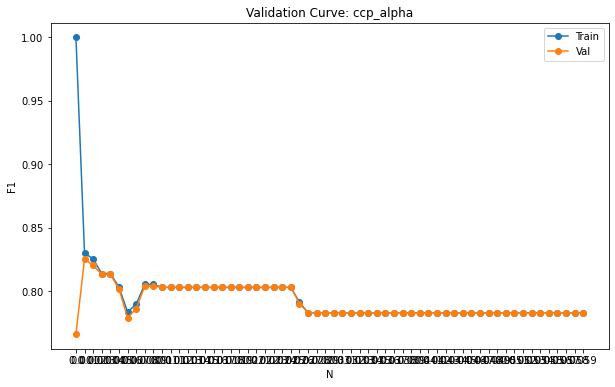

In [56]:
param='ccp_alpha'
param_range=[[alpha] for alpha in ccp_alphas]
tune(X_train, y_train, param, param_range, show_plot=True)

### Learning Curve

In [10]:
def plot_learning_curve_dt(X_train, y_train, kf):
    clf=DecisionTreeClassifier(max_depth=6, min_samples_split=870, min_samples_leaf=101, random_state=0)

    train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, scoring='f1', cv=kf, random_state=0, shuffle=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    fig, ax =plt.subplots()
    fig.set_size_inches(10,6)
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Validation")
    ax.legend()
    ax.set_xlabel('Train size')
    ax.set_ylabel('F1')
    ax.set_title('Learning Curve: F1 to Train Size')
    ax.set_ylim(0.75, 0.85)

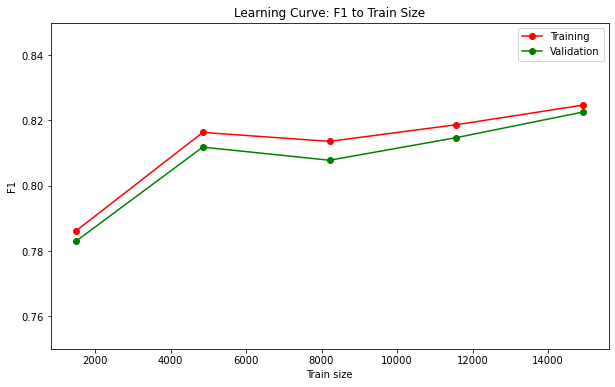

In [11]:
plot_learning_curve_dt(X_train, y_train, kf)

### Final Model

In [12]:
def final_model_dt(X_train, y_train, X_test, y_test):
    clf=DecisionTreeClassifier(max_depth=6, min_samples_split=870, min_samples_leaf=101, random_state=0)

    start=time.time()
    final=clf
    final.fit(X_train, y_train)

    pred_train=final.predict(X_train)
    pred_test=final.predict(X_test)

    train_score=f1_score(y_train, pred_train)
    test_score=f1_score(y_test, pred_test)
    
    cm=confusion_matrix(y_test, pred_test)
    runtime=round(time.time()-start, 3)
    
    print(color.BOLD+'Train F1: '+color.END, round(train_score, 3), '\n')
    print(color.BOLD+'Test F1: '+color.END, round(test_score, 3), '\n')
    print(color.BOLD+'Run Time:' +color.END, runtime , ' seconds', '\n')
    print(color.BOLD+'Confusion Matrix: '+color.END, '\n', cm)
    
    return train_score, test_score,  runtime, cm

In [14]:
train_score, test_score,  runtime, cm= final_model_dt(X_train, y_train,  X_test, y_test)

Train F1:  0.83 

Test F1:  0.659 

Run Time: 0.086  seconds 

Confusion Matrix:  
 [[5548 1866]
 [ 283 2072]]
